cuda
tensor([12.5327, 12.5327, 12.5327, 12.5327, 12.5327], device='cuda:0')
tensor([62.6630, 62.6630, 62.6630, 62.6630, 62.6630], device='cuda:0')
tensor(4.1775e-06, device='cuda:0')


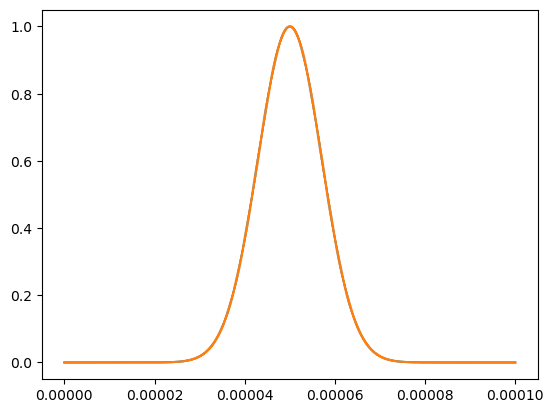

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from deap.tools import Statistics
from pulses import RadarPulseGenerator, CommPulseGenerator, generate_walsh_matrix
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)
t = torch.linspace(0, 1e-4, int(1e5), device=device)

mycdma_code = generate_walsh_matrix(8)*(-2) + 1

b = torch.tensor([+1, +1, +1, +1, +1, -1, -1, +1, +1, -1, +1, -1, +1], device=device)
# Define parameters
T = 1e-4       # Total duration of radar pulse (1e-4 seconds)
B = 1e6        # Bandwidth of radar pulse (1 MHz)
K = 5         # Number of users (OFDMA users)
L = 100        # Number of bits in radar pulse duration
Tb = T / L     # Duration of each bit interval
snr_db = 20
comm_pulse_kind = 'TDMA'
radar_pulse_kind = 'Gaussian'

myCommPulses = CommPulseGenerator(t, Tb, T, device)
myRadarPulses = RadarPulseGenerator(t, T=T, device=device)
snr = 10**(snr_db/10)

if comm_pulse_kind=='OFDMA':
    g_funcs = lambda l, k: myCommPulses.OFDMA_pulse(l, k-1)
    sigma2 = L*Tb/snr

if comm_pulse_kind=='TDMA':
    g_funcs = lambda l, k: myCommPulses.TDMA_pulse(l, k, K)
    sigma2 = L*Tb/snr/K

if comm_pulse_kind=='CDMA':
    g_funcs = lambda l, k: myCommPulses.CDMA_pulse(l, mycdma_code[k-1, :])
    sigma2 = L*Tb/snr

if radar_pulse_kind=='LFM':
    radar_pulse = myRadarPulses.LFM_pulse(B)

if radar_pulse_kind=='Gaussian':
    radar_pulse = myRadarPulses.Gaussian_pulse(B)

g_vec = torch.zeros((L*K, len(t)), device=device, dtype=torch.complex64)
for l in range(L):
    for k in range(K):
        g_vec[l*K + k, :] = g_funcs(l, k+1)
user_bit_energy = torch.sum(torch.abs(g_vec)**2, dim=1).reshape((L, K)) * (t[1]-t[0])
user_energy = user_bit_energy.sum(dim=0)

Q = torch.matmul(g_vec, g_vec.conj().T)*(t[1]-t[0])

R = radar_pulse.repeat(K*L, 1)

G = torch.diag(torch.matmul(R, g_vec.conj().T))*(t[1]-t[0])

c_opt = torch.matmul(G, torch.inverse(Q))
s_opt = torch.sum(c_opt[:, torch.newaxis].repeat(1, len(t)) * g_vec, dim=0)
user_bit_energy = (torch.sum(torch.abs(g_vec)**2, dim=1) * torch.abs(c_opt)**2).reshape((L, K)) * (t[1]-t[0])
user_energy = user_bit_energy.sum(dim=0)
print(user_energy / sigma2)

print()
print(torch.mean(torch.abs(s_opt - radar_pulse)**2))

plt.figure()
plt.plot(t.cpu(), radar_pulse.cpu().real)
plt.plot(t.cpu(), s_opt.cpu().real)

cuda
Iteration 0: Loss = 0.9111804962158203
Iteration 100: Loss = -0.39288273453712463
Iteration 200: Loss = -0.760744571685791
Iteration 300: Loss = -0.8443325757980347
Iteration 400: Loss = -0.8622786402702332
Iteration 500: Loss = -0.8661430478096008
Iteration 600: Loss = -0.8669897317886353
Iteration 700: Loss = -0.8671789169311523
Iteration 800: Loss = -0.867222011089325
Iteration 900: Loss = -0.8672319054603577
Iteration 1000: Loss = -0.8672344088554382
Iteration 1100: Loss = -0.8672349452972412
Iteration 1200: Loss = -0.8672350645065308
Iteration 1300: Loss = -0.8672350645065308
Iteration 1400: Loss = -0.8672351241111755
Iteration 1500: Loss = -0.8672351241111755
Iteration 1600: Loss = -0.8672350645065308
Iteration 1700: Loss = -0.8672350645065308
Iteration 1800: Loss = -0.8672351241111755
Iteration 1900: Loss = -0.8672351241111755
Iteration 2000: Loss = -0.8672351241111755
Iteration 2100: Loss = -0.8672351241111755
Iteration 2200: Loss = -0.8672351241111755
Iteration 2300: Loss

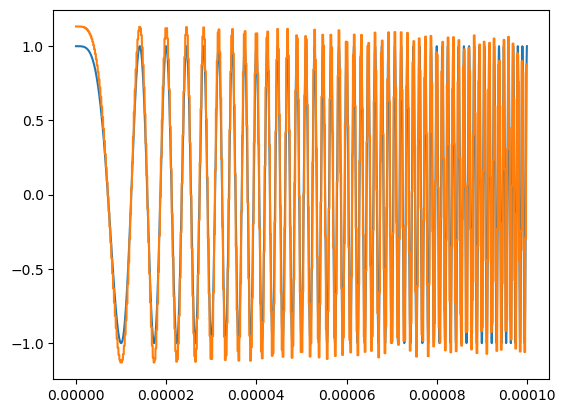

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from deap.tools import Statistics
from pulses import RadarPulseGenerator, CommPulseGenerator, generate_walsh_matrix
import torch
from multiprocessing import Pool

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)
t = torch.linspace(0, 1e-4, int(1e4), device=device)

mycdma_code = generate_walsh_matrix(8)*(-2) + 1

b = torch.tensor([+1, +1, +1, +1, +1, -1, -1, +1, +1, -1, +1, -1, +1], device=device)
# Define parameters
T = 1e-4       # Total duration of radar pulse (1e-4 seconds)
B = 1e6        # Bandwidth of radar pulse (1 MHz)
K = 5          # Number of users (OFDMA users)
L = 100        # Number of bits in radar pulse duration
Tb = T / L     # Duration of each bit interval

myCommPulses = CommPulseGenerator(t, Tb, T, device)
myRadarPulses = RadarPulseGenerator(t, T=T, device=device)

# g_funcs = lambda l, k: myCommPulses.OFDMA_pulse(l, k-1)
g_funcs = lambda l, k: myCommPulses.TDMA_pulse(l, k, K)
# g_funcs = lambda l, k: myCommPulses.CDMA_pulse(l, mycdma_code[k-1, :])

radar_pulse = myRadarPulses.LFM_pulse(B)
radar_power = torch.sum(torch.abs(radar_pulse)**2)*(t[1]-t[0])

g_vec = torch.zeros((L*K, len(t)), device=device, dtype=torch.complex64)
for l in range(L):
    for k in range(K):
        g_vec[l*K + k, :] = g_funcs(l, k+1)

# Fitness function
def fitness_fn(individual):
    """
    Compute the fitness (MSE) for the given coefficients.

    Parameters:
    - individual (torch.Tensor): Coefficients of size (L * K,).

    Returns:
    - mse (float): Mean squared error between synthesized and radar pulses.
    """
    # Ensure individual is split into real and imaginary parts
    N = len(individual) // 2
    real_val = individual[:N]  # Real part
    imag_val = individual[N:]  # Imaginary part

    # Combine real and imaginary parts into complex tensor
    c_opt = real_val + 1j * imag_val  # Combine parts to form a complex number
    s_opt = torch.sum(c_opt[:, None] * g_vec, dim=0)
    
    snr = (torch.abs(c_opt)**2).reshape((L, K)).sum(dim=0) * Tb / sigma2 #for OFDMA and CDMA
    mse = torch.mean(torch.abs(s_opt - radar_pulse) ** 2) # Compute MSE loss
    sumrate = torch.sum(torch.log2(1 + snr))
    return mse - 0.02*sumrate

# Initialize individual with real and imaginary parts
individual = torch.rand(K * L * 2, device=device, requires_grad=True) * 2 - 1

# Retain gradients for individual
individual.retain_grad()

for itr in range(5000):

    # Call the fitness function with the complex individual
    mse = fitness_fn(individual)
    
    # Backpropagate to compute gradients
    mse.backward(retain_graph=True)

    with torch.no_grad():  # No need to track gradients here
            individual -= 2 * individual.grad  # Update rule

    individual.grad.zero_()

    if itr % 100 == 0:
        print(f"Iteration {itr}: Loss = {mse.item()}")

individual = individual.detach()
N = len(individual) // 2
real_val = individual[:N]  # Real part
imag_val = individual[N:]  # Imaginary part

# Combine real and imaginary parts into complex tensor
c_opt = real_val + 1j * imag_val  # Combine parts to form a complex number
s_opt = torch.sum(c_opt[:, None] * g_vec, dim=0)

plt.figure()
plt.plot(t.cpu(), radar_pulse.cpu().real)
plt.plot(t.cpu(), s_opt.cpu().real)

cuda
gen	nevals	Avg    	Min    
0  	500   	4.32178	3.87735
1  	357   	4.38378	3.87735
2  	367   	4.24415	3.87271
3  	394   	4.03856	3.8651 
4  	376   	3.87325	3.85388
5  	359   	3.86414	3.84712
6  	371   	3.85289	3.82987
7  	370   	3.84031	3.80981
8  	381   	3.82717	3.78913
9  	382   	3.81033	3.7747 
10 	385   	3.79033	3.75498
11 	381   	3.77186	3.73537
12 	376   	3.75171	3.71357
13 	389   	3.73067	3.67754
14 	370   	3.70728	3.65487
15 	364   	3.68353	3.63532
16 	381   	3.6568 	3.60694
17 	384   	3.6336 	3.57397
18 	387   	3.60432	3.54689
19 	380   	3.57709	3.49491
20 	387   	3.54378	3.47727
21 	365   	3.50603	3.45574
22 	371   	3.48061	3.42003
23 	400   	3.45534	3.38353
24 	395   	3.42528	3.36137
25 	379   	3.3947 	3.33143
26 	365   	3.36472	3.31074
27 	385   	3.34082	3.27508
28 	382   	3.31476	3.25681
29 	384   	3.28756	3.2251 
30 	361   	3.26107	3.20556
31 	387   	3.23611	3.17423
32 	376   	3.2072 	3.12688
33 	379   	3.17817	3.11553
34 	391   	3.14701	3.08872
35 	371   	3.12045	3.03

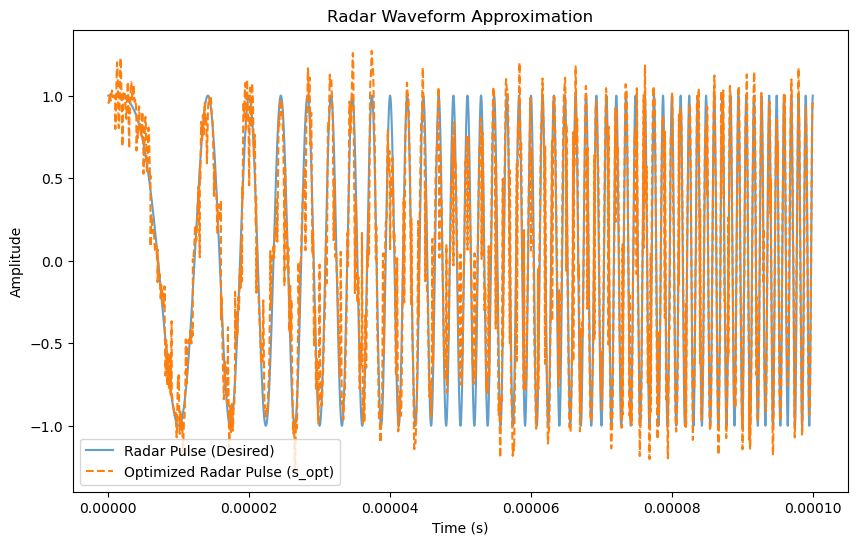

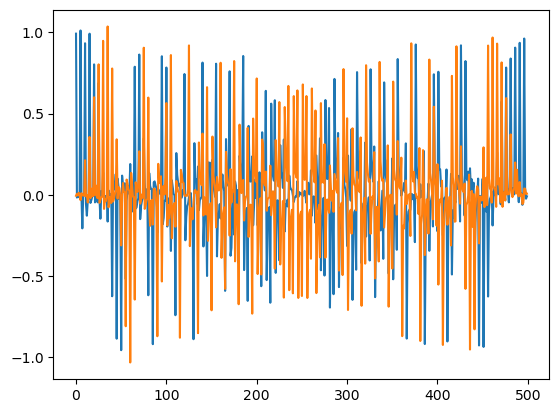

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from deap.tools import Statistics
from pulses import RadarPulseGenerator, CommPulseGenerator, generate_walsh_matrix
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)
t = torch.linspace(0, 1e-4, int(1e4), device=device)

mycdma_code = generate_walsh_matrix(8)*(-2) + 1

b = torch.tensor([+1, +1, +1, +1, +1, -1, -1, +1, +1, -1, +1, -1, +1], device=device)
# Define parameters
T = 1e-4       # Total duration of radar pulse (1e-4 seconds)
B = 1e6        # Bandwidth of radar pulse (1 MHz)
K = 5          # Number of users (OFDMA users)
L = 100        # Number of bits in radar pulse duration
Tb = T / L     # Duration of each bit interval

myCommPulses = CommPulseGenerator(t, Tb, T, device)
myRadarPulses = RadarPulseGenerator(t, T=T, device=device)

g_funcs = lambda l, k: myCommPulses.OFDMA_pulse(l, k-1)
# g_funcs = lambda l, k: myCommPulses.TDMA_pulse(l, k, K)
# g_funcs = lambda l, k: myCommPulses.CDMA_pulse(l, mycdma_code[k-1, :])

radar_pulse = myRadarPulses.LFM_pulse(B)
radar_power = torch.sum(torch.abs(radar_pulse)**2)*(t[1]-t[0])
g_vec = torch.zeros((L*K, len(t)), device=device, dtype=torch.complex64)
for l in range(L):
    for k in range(K):
        g_vec[l*K + k, :] = g_funcs(l, k+1)

# Fitness function
def fitness_fn(individual):
    """
    Compute the fitness (MSE) for the given coefficients.

    Parameters:
    - individual (torch.Tensor): Coefficients of size (L * K,).

    Returns:
    - mse (float): Mean squared error between synthesized and radar pulses.
    """
    N = len(individual) // 2
    # individual = np.clip(individual, -1, 1)
    real_val = torch.tensor(individual[:N], device=device, dtype=torch.float32)
    imag_val = torch.tensor(individual[N:], device=device, dtype=torch.float32)
    
    # Combine real and imaginary parts into complex tensor
    c_opt = real_val + 1j * imag_val
    c_opt = c_opt.to(torch.complex64)
    s_opt = torch.sum(c_opt[:, None] * g_vec, dim=0)
    s_opt_normalized = s_opt
    radar_pulse_normalized = radar_pulse
    mse = (torch.mean(torch.abs(s_opt_normalized - radar_pulse_normalized) ** 2)).item()
    return mse,

# DEAP setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.uniform, -1, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, L * K * 2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", fitness_fn)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.05, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=20)

# Genetic algorithm execution
population = toolbox.population(n=500)
n_generations = 1000

stats = Statistics(lambda ind: ind.fitness.values)
stats.register("Avg", lambda a: np.mean(a))
stats.register("Min", lambda a: np.min(a))
# Run the genetic algorithm
result, log = algorithms.eaSimple(
    population, toolbox, cxpb=0.7, mutpb=0.2, ngen=n_generations, verbose=True, stats=stats
)

# Extract the best individual
best_individual = tools.selBest(population, k=1)[0]
N = len(best_individual) // 2
real_val = torch.tensor(best_individual[:N], device=device, dtype=torch.float32)
imag_val = torch.tensor(best_individual[N:], device=device, dtype=torch.float32)

# Combine real and imaginary parts into complex tensor
c_opt_optimized = real_val + 1j * imag_val
c_opt_optimized = c_opt_optimized.to(torch.complex64).to(device)

# Synthesize optimized signal
s_opt_optimized = torch.sum(c_opt_optimized[:, None] * g_vec, dim=0)

# Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(t.cpu(), radar_pulse.cpu().real, label="Radar Pulse (Desired)", alpha=0.7)
plt.plot(t.cpu(), s_opt_optimized.cpu().real, label="Optimized Radar Pulse (s_opt)", linestyle="--")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Radar Waveform Approximation")
# plt.ylim([-1,1])
plt.show()

plt.figure()
plt.plot(c_opt_optimized.cpu().real)
plt.plot(c_opt_optimized.cpu().imag)

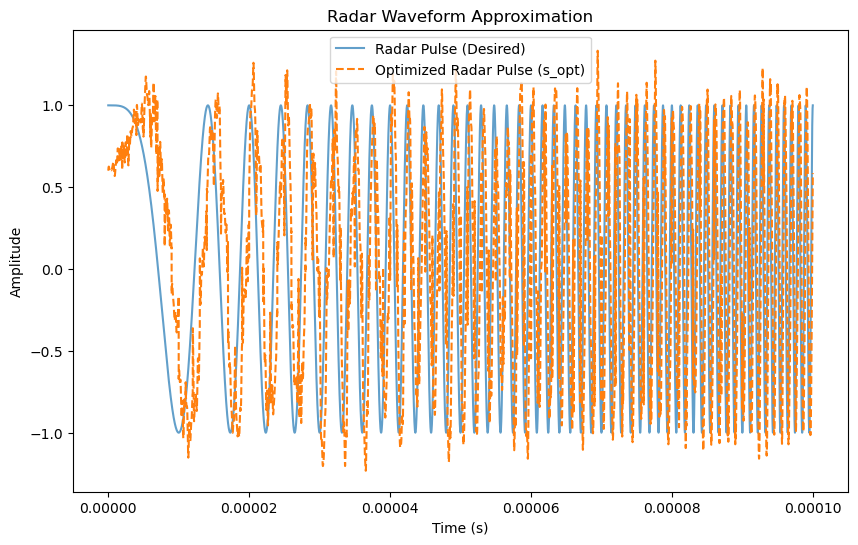

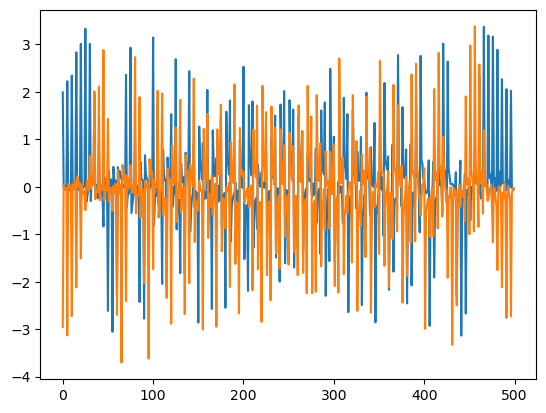

In [94]:
radar_pulse_power = (radar_pulse.abs()**2).sum()
s_opt_optimized2 = torch.sum(c_opt_optimized[:, None] * g_vec, dim=0) * torch.sqrt(radar_pulse_power / (s_opt_optimized.abs()**2).sum())

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(t.cpu(), radar_pulse.cpu().real, label="Radar Pulse (Desired)", alpha=0.7)
plt.plot(t.cpu(), s_opt_optimized2.cpu().real, label="Optimized Radar Pulse (s_opt)", linestyle="--")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Radar Waveform Approximation")
# plt.ylim([-1,1])
plt.show()

plt.figure()
plt.plot(c_opt_optimized.cpu().real)
plt.plot(c_opt_optimized.cpu().imag)